In [21]:
import gymnasium as gym
from vectorhash import build_vectorhash_architecture
from shifts import RatShift
from smoothing import RatSLAMSmoothing
from miniworld.params import DEFAULT_PARAMS
from miniworld_agent import MiniworldVectorhashAgent
import math
from preprocessing_cnn import PreprocessingCNN
import torch
from graph_utils import plot_imgs_side_by_side
from matplotlib import pyplot as plt
from graph_utils import error_test
import copy


### vhash
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

shapes = [(5, 5, 5), (8, 8, 8)]
N = 10


def make_env():
    params = DEFAULT_PARAMS.copy().no_random()
    # [
    #     "MiniWorld-CollectHealth-v0",
    #     "MiniWorld-FourRooms-v0",
    #     "MiniWorld-Hallway-v0",
    #     "MiniWorld-Maze-v0",
    #     "MiniWorld-MazeS2-v0",
    #     "MiniWorld-MazeS3-v0",
    #     "MiniWorld-MazeS3Fast-v0",
    #     "MiniWorld-OneRoom-v0",
    #     "MiniWorld-OneRoomS6-v0",
    #     "MiniWorld-OneRoomS6Fast-v0",
    #     "MiniWorld-PickupObjects-v0",
    #     "MiniWorld-PutNext-v0",
    #     "MiniWorld-RoomObjects-v0",
    #     "MiniWorld-Sidewalk-v0",
    #     "MiniWorld-Sign-v0",
    #     "MiniWorld-TMaze-v0",
    #     "MiniWorld-TMazeLeft-v0",
    #     "MiniWorld-TMazeRight-v0",
    #     "MiniWorld-ThreeRooms-v0",
    #     "MiniWorld-WallGap-v0",
    #     "MiniWorld-YMaze-v0",
    #     "MiniWorld-YMazeLeft-v0",
    #     "MiniWorld-YMazeRight-v0",
    # ]
    env = gym.make(
        "MiniWorld-CollectHealth-v0",
        max_episode_steps=-1,
        params=params,
        domain_rand=False,
    )
    min_x = env.get_wrapper_attr("min_x")
    max_x = env.get_wrapper_attr("max_x")
    min_z = env.get_wrapper_attr("min_z")
    max_z = env.get_wrapper_attr("max_z")

    limits = torch.tensor([max_x - min_x, max_z - min_z, 2 * math.pi]).float()
    return env, limits


env, limits = make_env()
model = build_vectorhash_architecture(
    shapes,
    N_h=600,
    input_size=128,
    initalization_method="by_sparsity",
    limits=limits,
    device=device,
    shift=RatShift(),
    smoothing=RatSLAMSmoothing(device=device),
)

cnn_preproc = PreprocessingCNN(
    device=device,
    latent_dim=128,
    input_channels=3,
    target_size=(224, 224),
    model_path="resnet18_adapter.pth"
)

#### agent
agent = MiniworldVectorhashAgent(model, env)

by_sparsity
module shapes:  [(5, 5, 5), (8, 8, 8)]
N_g     :  637
N_patts :  64000
N_h     :  600


/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


info for each h directly after learning it
h max, min, mean tensor(5.2339, device='cuda:0') tensor(0., device='cuda:0') tensor(1.6779, device='cuda:0')
h_from_s max, min, mean tensor(5.2327, device='cuda:0') tensor(0., device='cuda:0') tensor(1.6775, device='cuda:0')
h_from_s_denoised max, min, mean tensor(2.0544, device='cuda:0') tensor(1.4324, device='cuda:0') tensor(1.7157, device='cuda:0')
avg nonzero/greaterzero h from book: tensor(529, device='cuda:0') tensor(529, device='cuda:0')
avg nonzero/greaterzero h from s: tensor(529, device='cuda:0') tensor(529, device='cuda:0')
avg nonzero/greaterzero h from s denoised: tensor(600, device='cuda:0') tensor(600, device='cuda:0')
mse/cosinesimilarity h from book and h from s tensor(2.4995e-07, device='cuda:0') tensor([1.], device='cuda:0')
mse/cosinesimilarity h from book and h from s denoised tensor(1.4866, device='cuda:0') tensor([0.8100], device='cuda:0')
mse/cosinesimilarity s and s from h from s tensor(2.3358e-10, device='cuda:0') ten

/home/ezrahuang/Projects/rl-research/vectorhash/vectorhash.py:102: UserWarning: Using a target size (torch.Size([1, 600])) that is different to the input size (torch.Size([600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s),
/home/ezrahuang/Projects/rl-research/vectorhash/vectorhash.py:109: UserWarning: Using a target size (torch.Size([1, 600])) that is different to the input size (torch.Size([600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s_denoised),
/home/ezrahuang/Projects/rl-research/vectorhash/vectorhash.py:125: UserWarning: Using a target size (torch.Size([1, 128])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(s, s_from_h_from_s),


In [22]:
start_state = agent.vectorhash.scaffold.g
print('start state:', start_state)
print('grid limits:', agent.vectorhash.scaffold.grid_limits)
print('world limits:', limits)
print('scale factor:', agent.vectorhash.scaffold.scale_factor)

start state: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.,

In [23]:
begin = agent.get_true_pos(env)
end = begin + 1 / agent.vectorhash.scaffold.scale_factor
dist = torch.distributions.uniform.Uniform(low=begin, high=end)
samples = dist.sample((N,))
grid_states = agent.vectorhash.scaffold.scale_factor * (samples - begin)

In [24]:
print("samples:", samples)
print("grid states:", grid_states)

samples: tensor([[2.3849, 6.8330, 1.5564],
        [2.4302, 6.8192, 1.6895],
        [2.2481, 7.0570, 1.6062],
        [2.3728, 6.8090, 1.6990],
        [2.2812, 7.0794, 1.6264],
        [2.4000, 6.8074, 1.6936],
        [2.5376, 6.9739, 1.5961],
        [2.5838, 6.9458, 1.6591],
        [2.2176, 7.0485, 1.6983],
        [2.6130, 6.8937, 1.6248]], device='cuda:0')
grid states: tensor([[0.4277, 0.1566, 0.0430],
        [0.5409, 0.1220, 0.8904],
        [0.0858, 0.7166, 0.3604],
        [0.3974, 0.0966, 0.9511],
        [0.1686, 0.7726, 0.4890],
        [0.4656, 0.0926, 0.9164],
        [0.8096, 0.5088, 0.2959],
        [0.9250, 0.4386, 0.6968],
        [0.0096, 0.6953, 0.9465],
        [0.9979, 0.3084, 0.4784]], device='cuda:0')


info for each h directly after learning it
h max, min, mean tensor(5.2339, device='cuda:0') tensor(0., device='cuda:0') tensor(1.6779, device='cuda:0')
h_from_s max, min, mean tensor(5.2342, device='cuda:0') tensor(0., device='cuda:0') tensor(1.6780, device='cuda:0')
h_from_s_denoised max, min, mean tensor(2.0544, device='cuda:0') tensor(1.4324, device='cuda:0') tensor(1.7157, device='cuda:0')
avg nonzero/greaterzero h from book: tensor(529, device='cuda:0') tensor(529, device='cuda:0')
avg nonzero/greaterzero h from s: tensor(529, device='cuda:0') tensor(529, device='cuda:0')
avg nonzero/greaterzero h from s denoised: tensor(600, device='cuda:0') tensor(600, device='cuda:0')
mse/cosinesimilarity h from book and h from s tensor(1.6807e-08, device='cuda:0') tensor([1.0000], device='cuda:0')
mse/cosinesimilarity h from book and h from s denoised tensor(1.4866, device='cuda:0') tensor([0.8100], device='cuda:0')
mse/cosinesimilarity s and s from h from s tensor(0.0436, device='cuda:0') ten

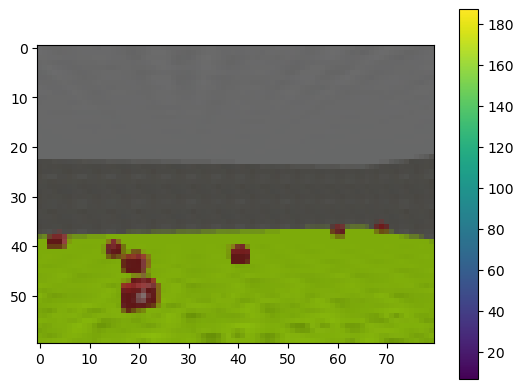

In [25]:
first_img, first_pos = agent._env_reset(env)
first_img, first_pos = agent._obs_postpreprocess(agent.env.step(4), 4)
m = plt.imshow(first_img)
plt.colorbar(m)
agent.vectorhash.store_memory(s=agent.preprocessor.encode(first_img))

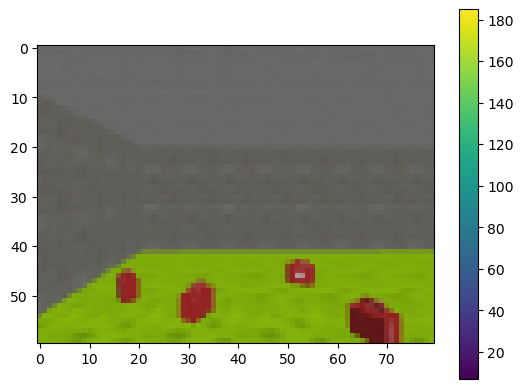

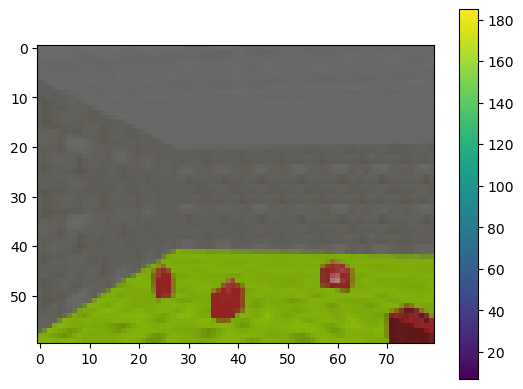

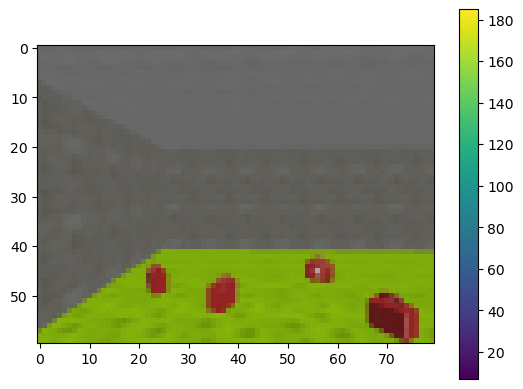

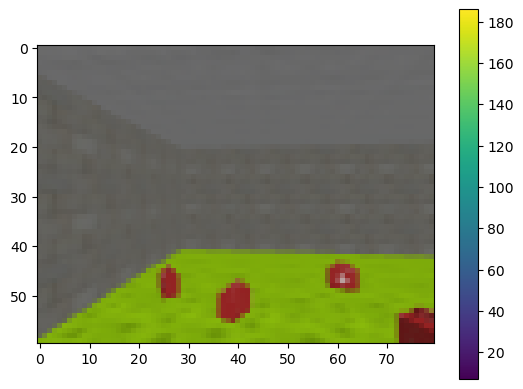

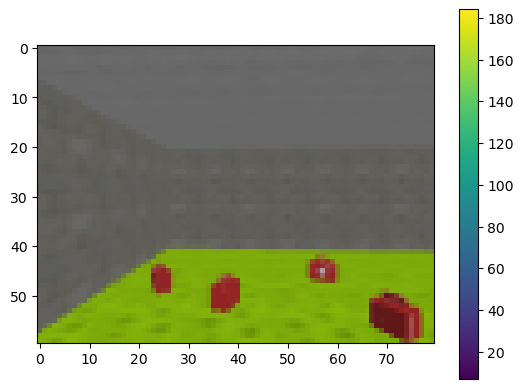

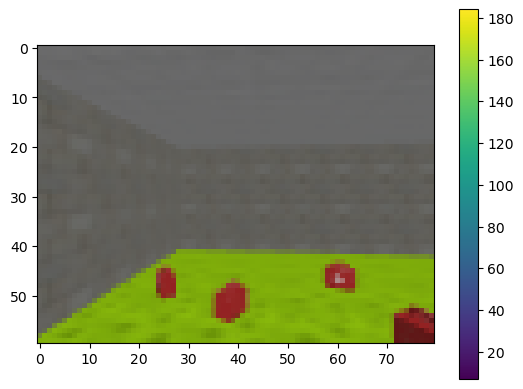

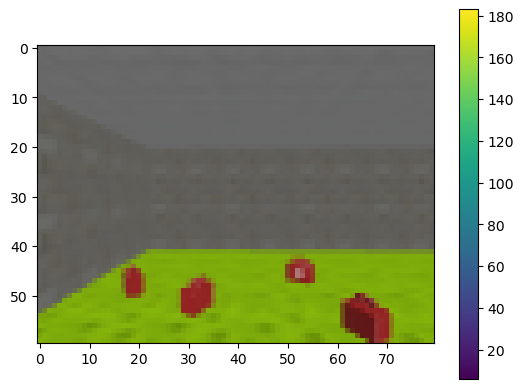

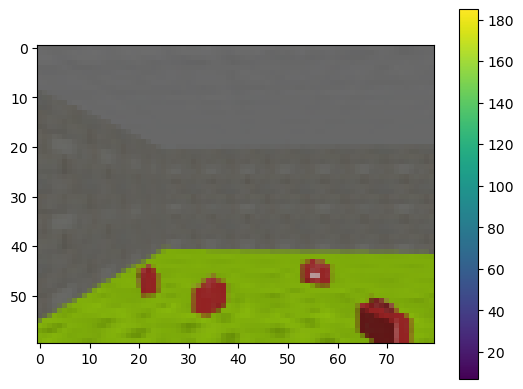

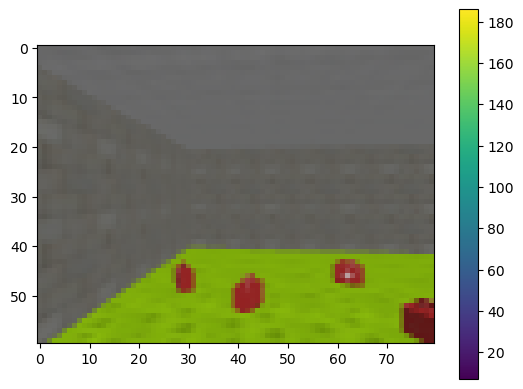

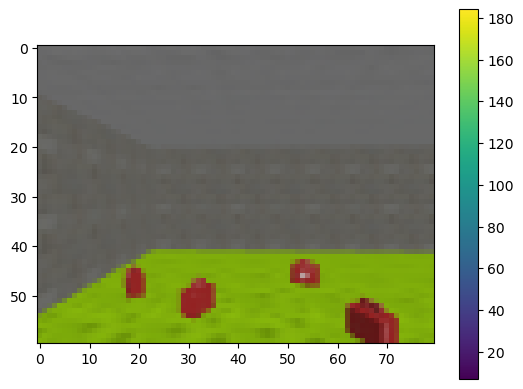

In [26]:
imgs = []
states = []
for sample in samples:
    pos = sample.cpu().numpy()
    agent.set_agent_pos(pos)
    img , _ = agent._obs_postpreprocess(agent.env.step(4), 4)
    obs = agent.preprocessor.encode(img)
    g = agent.vectorhash.scaffold.denoise(
        agent.vectorhash.scaffold.grid_from_hippocampal(
            agent.vectorhash.hippocampal_sensory_layer.hippocampal_from_sensory(obs)
        )
    )
    m = plt.imshow(img)
    plt.colorbar(m)
    plt.show()
    imgs.append(img)
    states.append(g)

In [27]:
print(states)

[tensor([[0.0100, 0.0080, 0.0079, 0.0078, 0.0080, 0.0080, 0.0076, 0.0078, 0.0080,
         0.0080, 0.0083, 0.0076, 0.0080, 0.0083, 0.0080, 0.0082, 0.0082, 0.0081,
         0.0080, 0.0078, 0.0077, 0.0076, 0.0080, 0.0079, 0.0082, 0.0080, 0.0080,
         0.0081, 0.0084, 0.0081, 0.0077, 0.0080, 0.0080, 0.0079, 0.0078, 0.0078,
         0.0079, 0.0081, 0.0081, 0.0081, 0.0080, 0.0080, 0.0080, 0.0081, 0.0079,
         0.0079, 0.0077, 0.0078, 0.0079, 0.0079, 0.0074, 0.0081, 0.0076, 0.0081,
         0.0078, 0.0080, 0.0079, 0.0083, 0.0082, 0.0083, 0.0077, 0.0080, 0.0079,
         0.0080, 0.0079, 0.0082, 0.0077, 0.0080, 0.0076, 0.0083, 0.0081, 0.0081,
         0.0078, 0.0080, 0.0079, 0.0083, 0.0082, 0.0080, 0.0078, 0.0083, 0.0085,
         0.0082, 0.0082, 0.0081, 0.0080, 0.0081, 0.0080, 0.0082, 0.0078, 0.0080,
         0.0082, 0.0079, 0.0082, 0.0077, 0.0079, 0.0078, 0.0081, 0.0081, 0.0081,
         0.0078, 0.0081, 0.0077, 0.0081, 0.0081, 0.0079, 0.0077, 0.0081, 0.0083,
         0.0080, 0.0081, 0.

Text(0.5, 0.98, 'probability mass in each distribution (with cnn)')

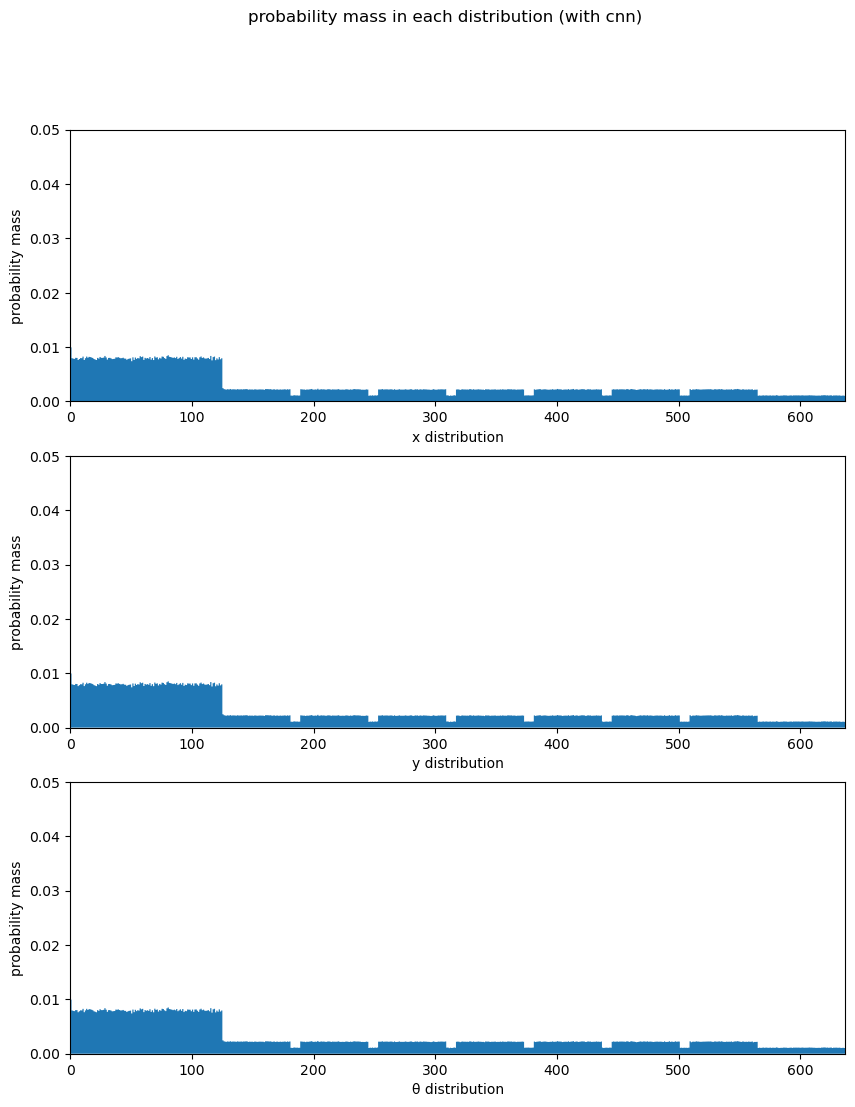

In [28]:
import matplotlib.pyplot as plt
from matplotlib import axes
from graph_utils import plot_probability_distribution_on_ax

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

plot_probability_distribution_on_ax(states[0][0].cpu(), axs[0])
plot_probability_distribution_on_ax(states[1][0].cpu(), axs[1])
plot_probability_distribution_on_ax(states[2][0].cpu(), axs[2])

for i in range(3):
  a: axes.Axes = axs[i]
  a.set_ylim(0, 0.05)
  a.set_xlim(0, len(states[0][0]))
  a.set_ylabel('probability mass')
  
axs[0].set_xlabel('x distribution')
axs[1].set_xlabel('y distribution')
axs[2].set_xlabel('θ distribution')

fig.suptitle('probability mass in each distribution (with cnn)')

In [29]:
errors = torch.zeros(N, 3)

scaffold_copy = copy.deepcopy(model.scaffold)
for i, state in enumerate(states):
  scaffold_copy.modules = scaffold_copy.modules_from_g(state[0])
  for d in range(3):
    errors[i, d] = error_test(0, scaffold_copy.expand_distribution(d))

In [30]:
print(errors)

tensor([[10.0105, 10.0106,  9.9997],
        [10.0105, 10.0106,  9.9997],
        [10.0105, 10.0106,  9.9997],
        [10.0105, 10.0106,  9.9997],
        [10.0105, 10.0106,  9.9997],
        [10.0105, 10.0106,  9.9997],
        [10.0105, 10.0106,  9.9997],
        [10.0105, 10.0106,  9.9997],
        [10.0105, 10.0106,  9.9997],
        [10.0105, 10.0106,  9.9997]])
